In [70]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
import seaborn as sns
import catboost
from sklearn.model_selection import GridSearchCV

### Just CatBoost

In [71]:
df = pd.read_csv('mtp_dataset_3_mod.csv')
boring = df[df['life_mode'] == 'boring'].index
df['body_size'] = np.log(df['body_size']) #log transforming body size
df = df.assign(survival_status=df.survival_status.eq('Extinct').astype(int)) #encoding "extinct" as 1 and "survived" as 0
df.drop(['order'], axis = 1, inplace = True) #dropping the column "order"
df.replace('boring', 'infaunal', inplace = True)
df

,lithology,life_mode,motility,feeding_mode,shell_mineralogy,species_richness,ornamentation,environmental_breadth,geographic_range,occurrence,body_size,survival_status
0,mixed,epifaunal,stationary,suspension feeder,aragonite,1,2,2,1,2,3.056486,0
1,siliciclastic,epifaunal,mobile,suspension feeder,aragonite,1,2,4,4,10,4.948570,0
2,siliciclastic,infaunal,mobile,deposit feeder,aragonite,1,2,1,1,1,3.540013,0
3,siliciclastic,infaunal,mobile,deposit feeder,aragonite,4,2,5,4,33,1.085132,0
4,mixed,epifaunal,stationary,suspension feeder,low Mg calcite,3,2,2,6,62,4.377049,0
...,...,...,...,...,...,...,...,...,...,...,...,...
303,siliciclastic,epifaunal,stationary,suspension feeder,aragonite,1,2,1,1,5,3.092152,1
304,siliciclastic,infaunal,stationary,suspension feeder,aragonite,1,2,1,1,1,2.973484,0
305,siliciclastic,infaunal,mobile,suspension feeder,aragonite,3,2,3,2,6,4.261218,1
306,siliciclastic,infaunal,mobile,deposit feeder,aragonite,5,1,4,2,15,3.431797,0


In [72]:
X = df.drop("survival_status", axis=1)
y = df.survival_status

In [104]:
class MyScaler:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        return self

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)
    
    def get_params(self,X, y = None):
        return X.columns.to_list()

In [107]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
from catboost import CatBoostClassifier

# Split data into train and test sets
smote = SMOTENC(categorical_features=[0,1,2,3,4], random_state=42)
X_res, y_res = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2, random_state = 27)


# Define column transformer for preprocessing
categorical_features = [0,1,2,3,4]  # Example categorical feature indices
numerical_features = [5,6,7,8,9,10]  # Example numerical feature indices
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

# Define pipeline with preprocessing, SMOTE, and CatBoost classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('catboost', CatBoostClassifier(random_seed=42))
])

# Fit pipeline to training data
pipeline.fit(X_train, y_train)

# Evaluate pipeline on test data
accuracy = pipeline.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

Learning rate set to 0.006556
0:	learn: 0.6911563	total: 3.28ms	remaining: 3.28s
1:	learn: 0.6891886	total: 4.72ms	remaining: 2.36s
2:	learn: 0.6872062	total: 6.06ms	remaining: 2.01s
3:	learn: 0.6853476	total: 7.31ms	remaining: 1.82s
4:	learn: 0.6838375	total: 8.79ms	remaining: 1.75s
5:	learn: 0.6818541	total: 10.4ms	remaining: 1.73s
6:	learn: 0.6799124	total: 12.5ms	remaining: 1.77s
7:	learn: 0.6779971	total: 14ms	remaining: 1.73s
8:	learn: 0.6763982	total: 15.4ms	remaining: 1.7s
9:	learn: 0.6743021	total: 16.6ms	remaining: 1.65s
10:	learn: 0.6723126	total: 19.4ms	remaining: 1.74s
11:	learn: 0.6703450	total: 20.5ms	remaining: 1.69s
12:	learn: 0.6689328	total: 21.7ms	remaining: 1.65s
13:	learn: 0.6674790	total: 23.2ms	remaining: 1.63s
14:	learn: 0.6659572	total: 24.6ms	remaining: 1.62s
15:	learn: 0.6649413	total: 26.1ms	remaining: 1.6s
16:	learn: 0.6626123	total: 27.4ms	remaining: 1.58s
17:	learn: 0.6608803	total: 28.6ms	remaining: 1.56s
18:	learn: 0.6593148	total: 30.1ms	remaining: 1.

In [108]:
feature_names1 = pipeline.named_steps['preprocessor'].get_feature_names_out()
print(feature_names1)

['cat__lithology_carbonate' 'cat__lithology_mixed'
 'cat__lithology_siliciclastic' 'cat__life_mode_epifaunal'
 'cat__life_mode_infaunal' 'cat__life_mode_semi-infaunal'
 'cat__motility_mobile' 'cat__motility_stationary'
 'cat__feeding_mode_carnivore' 'cat__feeding_mode_chemosymbiotic'
 'cat__feeding_mode_deposit feeder' 'cat__feeding_mode_herbivore'
 'cat__feeding_mode_photosymbiotic' 'cat__feeding_mode_suspension feeder'
 'cat__shell_mineralogy_aragonite' 'cat__shell_mineralogy_low Mg calcite'
 'num__species_richness' 'num__ornamentation' 'num__environmental_breadth'
 'num__geographic_range' 'num__occurrence' 'num__body_size']


In [94]:
## get pipeline feature names
feature_names = ['lithology_carbonate', 'lithology_mixed', 'lithology_others', 'lithology_siliciclastic', 'life_mode_epifaunal',
                'life_mode_infaunal',
                'life_mode_semi-infaunal', 'motility_mobile',
                'motility_stationary', 'feeding_mode_carnivore',
                    'feeding_mode_chemosymbiotic',
                    'feeding_mode_deposit feeder',
                    'feeding_mode_photosymbiotic',
                    'feeding_mode_suspension feeder', 'shell_mineralogy_aragonite',
                        'shell_mineralogy_low Mg calcite', 'species_richness', 'ornamentation', 'environmental_breadth', 'geographic_range', 'occurrence', 'body_size']

In [109]:
#function to create and print the confusion matrix and the precision recall and F1 scores
from sklearn.metrics import confusion_matrix
def plot_cm(classifier, predictions):
    cm = confusion_matrix(y_test, predictions)
    
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap='RdBu')
    classNames = ['Extinct','Survived']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), 
                     horizontalalignment='center', color='Yellow')
    
    plt.show()
        
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp+tn) / (tp + tn + fp + fn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    F1 = 2*recall*precision/(recall+precision)

    print('Accuracy={0:0.3f}'.format(accuracy))
    print('Recall={0:0.3f}'.format(recall),'\nPrecision={0:0.3f}'.format(precision))
    print('F1={0:0.3f}'.format(F1))

#function to create the precision- recall curve
from sklearn.metrics import average_precision_score, precision_recall_curve
def plot_aucprc(classifier, scores):
    precision, recall, _ = precision_recall_curve(y_test, scores, pos_label=0)
    average_precision = average_precision_score(y_test, scores)

    print('Average precision-recall score: {0:0.3f}'.format(
          average_precision))

    plt.plot(recall, precision, label='area = %0.3f' % average_precision, color="green")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend(loc="best")
    plt.show()

#function to create the ROC cureve
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
def plot_aucroc(classifier):
    probs = classifier.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

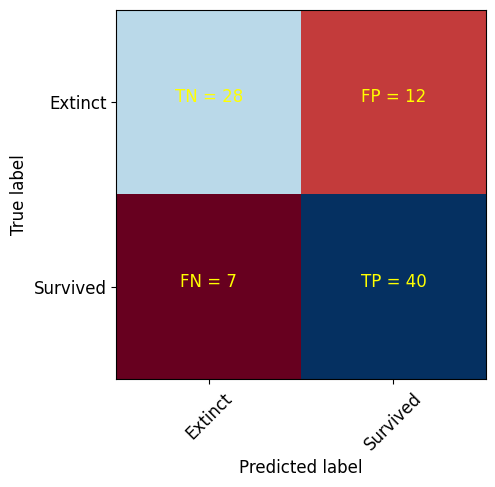

Accuracy=0.782
Recall=0.851 
Precision=0.769
F1=0.808
Average precision-recall score: 0.871


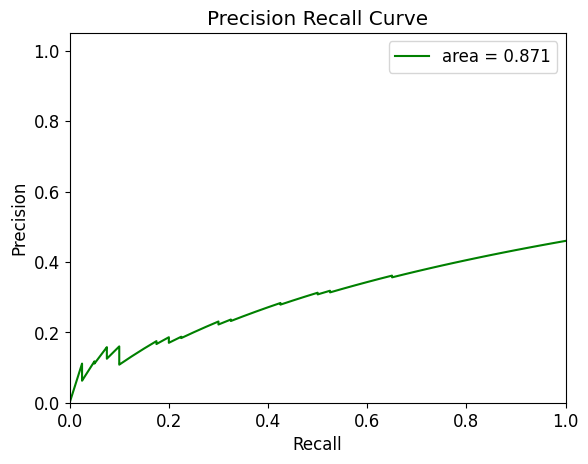

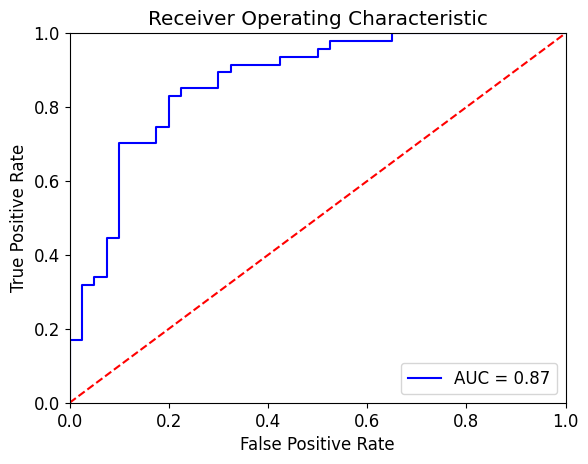

In [110]:
#Make predictions
y_pred = pipeline.predict(X_test)
try:
    scores = pipeline.decision_function(X_test)
except:
    scores = pipeline.predict_proba(X_test)[:,1]

#Make plots
plot_cm(pipeline, y_pred)
plot_aucprc(pipeline, scores)
plot_aucroc(pipeline)

### SHAP

In [78]:
# def model_predict(data_asarray):
#     data_asframe =  pd.DataFrame(data_asarray, columns=feature_names)
#     return pipeline.predict_proba(data_asframe)

In [79]:
# def model_predict(X_test):
#     data_asframe =  pd.DataFrame(X_test, columns=feature_names)
#     return pipeline.predict_proba(data_asframe)

In [80]:
# def model_predict(X_test):
#     return pipeline.predict_proba(X_test)

In [111]:
import shap
shap.initjs()

In [112]:
X_train

,lithology,life_mode,motility,feeding_mode,shell_mineralogy,species_richness,ornamentation,environmental_breadth,geographic_range,occurrence,body_size
106,mixed,epifaunal,stationary,suspension feeder,aragonite,1,2,2,1,5,4.552194
20,carbonate,epifaunal,stationary,suspension feeder,aragonite,1,2,1,1,1,2.124390
195,carbonate,infaunal,mobile,deposit feeder,aragonite,1,3,2,2,2,2.075111
44,mixed,infaunal,stationary,suspension feeder,aragonite,3,2,4,3,276,3.346930
248,mixed,infaunal,mobile,suspension feeder,aragonite,1,2,2,1,21,3.685745
...,...,...,...,...,...,...,...,...,...,...,...
312,siliciclastic,infaunal,mobile,suspension feeder,aragonite,1,2,2,1,5,3.444772
31,mixed,semi-infaunal,stationary,suspension feeder,aragonite,1,1,1,1,4,2.835440
328,siliciclastic,epifaunal,stationary,suspension feeder,low Mg calcite,1,1,1,1,1,2.838090
184,siliciclastic,epifaunal,stationary,suspension feeder,low Mg calcite,1,2,2,1,3,3.049262


In [115]:
explainer = shap.TreeExplainer(pipeline.named_steps["catboost"])
shap_values = explainer.shap_values(pipeline[:-1].transform(X_train))


shap.force_plot(explainer.expected_value, shap_values[0,:], feature_names, link='logit')

#0 - 106
# Arcida,mixed,epifaunal,stationary,suspension feeder,aragonite,1,2,2,1,5,94.8402581,Extinct

In [122]:
shap.force_plot(explainer.expected_value, shap_values[1,:], feature_names, link='logit')

# 1 - 20
# Arcida,carbonate,epifaunal,stationary,suspension feeder,aragonite,1,2,1,1,1,8.36779541,Survived

In [125]:
shap.force_plot(explainer.expected_value, shap_values[2,:], feature_names, link='logit')

In [126]:
shap.force_plot(explainer.expected_value, shap_values[3,:], feature_names, link='logit')
#3 - 44
#Pholadida,mixed,infaunal,stationary,suspension feeder,aragonite,3,2,4,3,276,28.4153532,Survived

In [130]:
shap.force_plot(explainer.expected_value, shap_values[343,:], feature_names, link='logit')
#343 - 31
# Ostreida,mixed,semi-infaunal,stationary,suspension feeder,aragonite,1,1,1,1,4,17.0378989,Extinct

In [127]:
shap.force_plot(explainer.expected_value, shap_values[346,:], feature_names, link='logit')
#346 - 19
#Mytilida,mixed,epifaunal,stationary,suspension feeder,aragonite,1,2,1,1,1,47.2440472,Survived

explainer = shap.KernelExplainer(pipeline.predict, X_train)
shap_values = explainer.shap_values(X_test)

features = df.drop(['survival_status'], axis=1).columns.tolist() #not needed for this plot
shap_df = pd.DataFrame(shap_values, columns=pd.Index(features, name='features')) #not needed for this plot

shap.summary_plot(shap_values, X_train, plot_type="bar")

In [116]:
X_train1 = pipeline.named_steps['preprocessor'].fit_transform(X_train)

In [117]:
X_train_df = pd.DataFrame(X_train1, columns=feature_names)

In [18]:
# ## Store the best fitted classifier and its booster
# binary_est = xgb_bin_grid.best_estimator_ # from tuning with GridSearchCV
# binary_model = binary_est.named_steps['xgb'].get_booster()
# model = pipeline.named_steps['catboost']

In [118]:
new_explainer= shap.TreeExplainer(pipeline.named_steps['catboost'])
shap_vals = new_explainer.shap_values(X_train_df)

In [39]:
# new_explainer= shap.KernelExplainer(pipeline.predict, X_train)
# shap_vals = new_explainer.shap_values(X_train)

In [121]:
shap.force_plot(new_explainer.expected_value,
                              shap_vals[0,:],
                              X_train_df.iloc[0,:], link = 'logit')

In [123]:
shap.force_plot(new_explainer.expected_value,
                              shap_vals[1,:],
                              X_train_df.iloc[1,:], link = 'logit')

In [45]:
def shap_force(clf, clf_step_name, index, X_train_df, y_train, explainer, shap_vals):
    ## Store model prediction and ground truth label
    pred = clf.named_steps[clf_step_name].predict(X_train_df.iloc[index,:])
    true_label = y_train.iloc[index]
    
    
    ## Assess accuracy of prediction
    if true_label == pred:
        accurate = 'Correct!'
    else:
        accurate = 'Incorrect'
    
    
    ## Print output that checks model's prediction against true label
    print('***'*12)
    # Print ground truth label for row at index
    print(f'Ground Truth Label: {true_label}')
    print()
    # Print model prediction for row at index
    print(f'Model Prediction:  {pred} -- {accurate}')
    print('***'*12)
    print()
    
    
    ## Plot the prediction's explanation
    fig = shap.force_plot(explainer.expected_value,
                              shap_vals[index,:],
                              X_train_df.iloc[index,:])
    
    
    return fig

In [46]:
shap_force(pipeline, 
           'catboost', # name of fitted classifier step in pipeline
           0, X_train, y_train, 
           new_explainer, 
           shap_vals)

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=0]="mixed": Cannot convert 'b'mixed'' to float

In [27]:
X_test

,lithology,life_mode,motility,feeding_mode,shell_mineralogy,species_richness,ornamentation,environmental_breadth,geographic_range,occurrence,body_size
104,siliciclastic,epifaunal,stationary,suspension feeder,aragonite,1,2,1,1,2,3.665039
82,mixed,infaunal,mobile,suspension feeder,aragonite,6,2,5,5,194,4.299424
415,mixed,infaunal,mobile,suspension feeder,aragonite,2,2,4,4,151,4.302487
395,mixed,infaunal,mobile,suspension feeder,aragonite,1,2,3,3,94,4.354230
311,mixed,infaunal,mobile,suspension feeder,aragonite,1,1,1,1,4,2.810904
...,...,...,...,...,...,...,...,...,...,...,...
296,mixed,infaunal,mobile,chemosymbiotic,aragonite,1,2,2,2,30,3.802422
430,mixed,infaunal,mobile,suspension feeder,aragonite,1,1,3,2,15,2.550307
315,mixed,infaunal,mobile,suspension feeder,aragonite,1,2,1,2,26,3.917547
35,siliciclastic,infaunal,mobile,suspension feeder,aragonite,1,1,2,2,43,3.632148


https://datascience.stackexchange.com/questions/52476/how-to-use-shap-kernal-explainer-with-pipeline-models
https://towardsdatascience.com/deep-dive-into-catboost-functionalities-for-model-interpretation-7cdef669aeed

!!!!! https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195